In [166]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm 
import scienceplots

The goal of this project is to create a generative model that is able to generate alternative smiles that could have clinical potential. Oftentimes, human clinical trials take a lot of time and effort so it is important to vet out drugs that have little clinical significance early. 

We will start by doing some EDA, then clean the data, create a model, and finetune parameters. 

In [11]:
path = "../wip_chem/chembl.csv"
chembl = pd.read_csv(path, delimiter= ';')

chembl.head()

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Smiles,Inchi Key
0,CHEMBL1201641,INSULIN ZINC SUSP EXTENDED RECOMBINANT HUMAN,HUMULIN U|INSULIN ZINC SUSP EXTENDED RECOMBINA...,Protein,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEMBL386120,NaN,NaN,Protein,NaN,1047.28,2.0,2.0,None,None,...,None,None,None,None,1046.5814,None,None,C54H74N14O8,CCCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](Cc1c...,USRUQIUGZKUBSE-ZSXJDPQMSA-N
2,CHEMBL2107984,PEGALDESLEUKIN,PEGALDESLEUKIN,Protein,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEMBL3238082,NaN,NaN,Protein,NaN,1427.76,1.0,1.0,None,None,...,None,None,None,None,1426.5542,None,None,C63H90N14O16S4,CCCC[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CSSC[C@...,QWLMGMUSVNPXPA-GOVHZBJUSA-N
4,CHEMBL1253405,NaN,NaN,Protein,NaN,2408.57,1.0,1.0,None,None,...,None,None,None,None,2407.1081,None,None,C107H154N28O36,CC[C@H](C)[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H...,AFKQKYDXLSEPHU-NSQZWSSQSA-N


In [12]:
chembl.columns

Index(['ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP',
       'Polar Surface Area', 'HBA', 'HBD', '#RO5 Violations',
       '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted', 'CX Acidic pKa',
       'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'Inorganic Flag', 'Heavy Atoms', 'HBA (Lipinski)',
       'HBD (Lipinski)', '#RO5 Violations (Lipinski)',
       'Molecular Weight (Monoisotopic)', 'Np Likeness Score',
       'Molecular Species', 'Molecular Formula', 'Smiles', 'Inchi Key'],
      dtype='object')

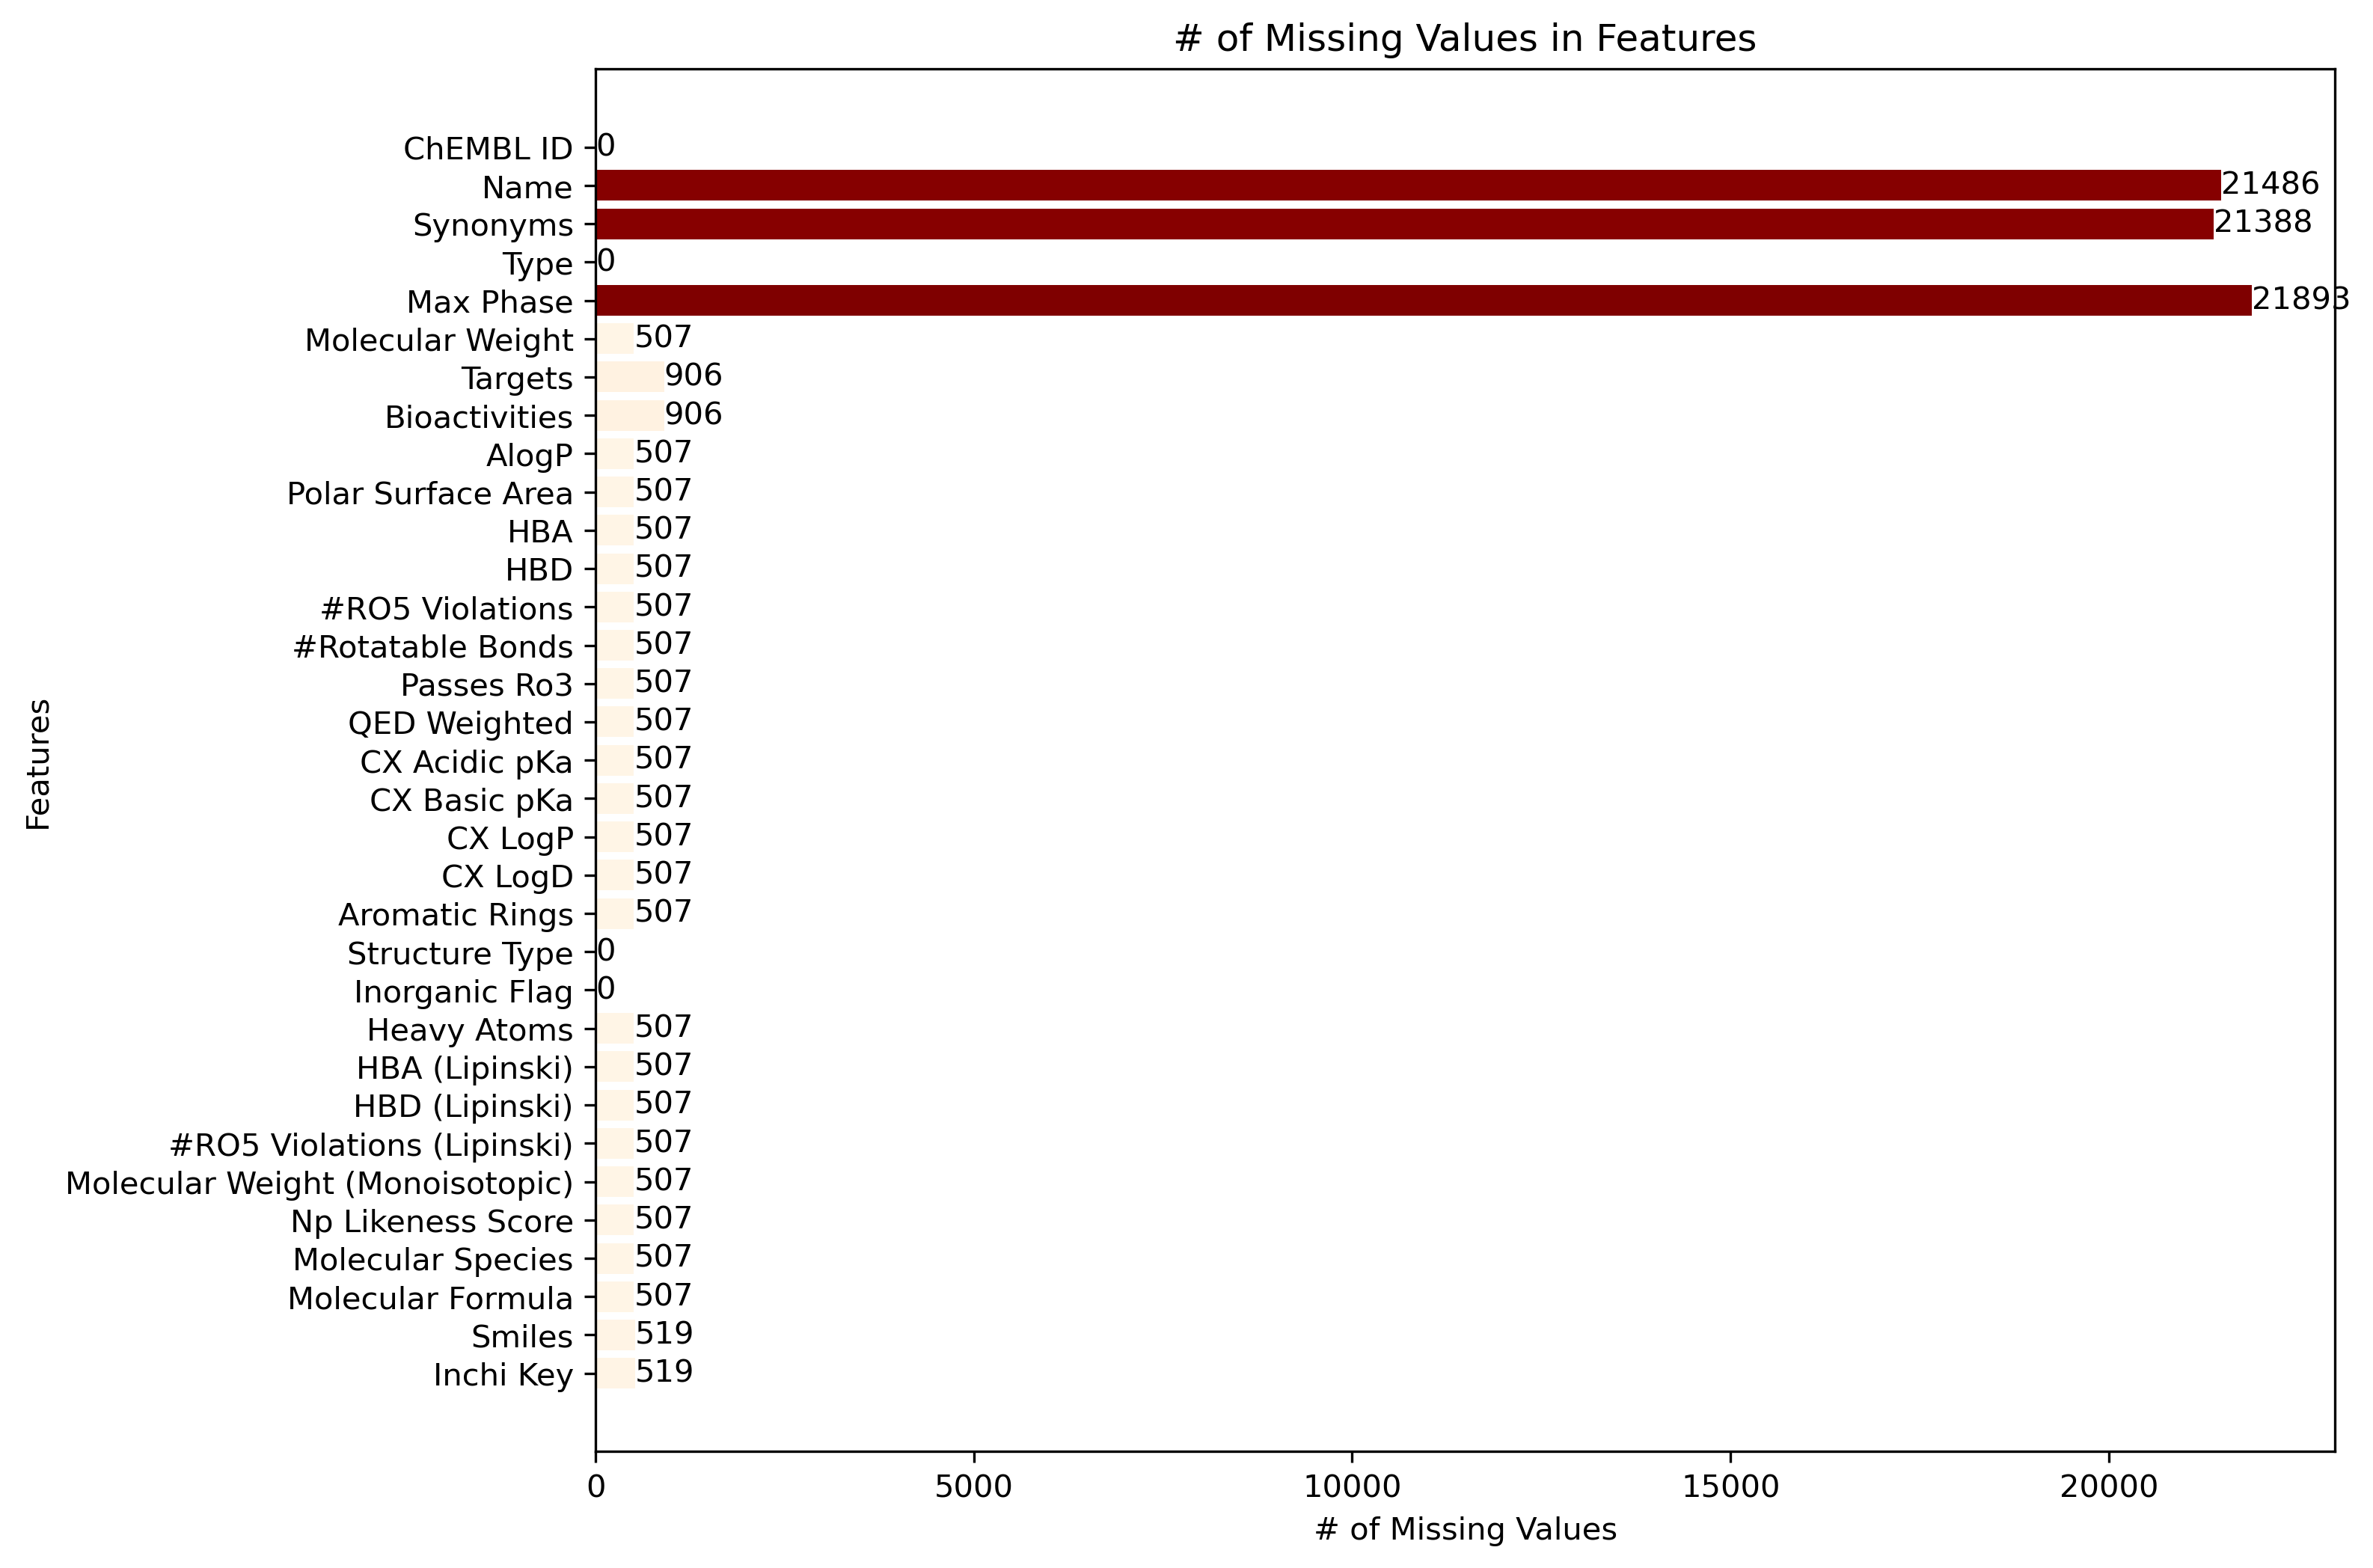

In [180]:
# Count number of missing in each column 
missing_values = chembl.isnull().sum()


# Style
plt.style.use("default")
plt.figure(figsize=(10, 8), dpi=300)

# Normalize the missing values to range [0, 1]
normalized_missing_values = missing_values / max(missing_values)
cmap = plt.cm.get_cmap("OrRd")
colors = cmap(normalized_missing_values)

# Plotting
null_val_bar = plt.barh(chembl.columns[::-1], missing_values[::-1], color = colors[::-1])

# Title and Labels 
plt.title('# of Missing Values in Features')
plt.bar_label(null_val_bar)
plt.ylabel('Features', color = 'black')
plt.xlabel('# of Missing Values', color = 'black')

# Show 
plt.show()


